# Nearest Neighbours

First install and import needed packages and libraries

In [1]:
# !pip install numpy pandas matplotlib scikit-learn missingno pyarrow pynndescent sentence-transformers tqdm

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

We're going to use [Codon usage](https://archive.ics.uci.edu/ml/datasets/Codon+usage) dataset. It has been presented in [this article](https://www.nature.com/articles/s41598-023-28965-7)

The dataset uses 5 classes - kingdoms of the organism with a given genome distribution of codons in its sequential RNA.

1. Archaea
2. Bacteria
3. Eukariota
4. Viruses
5. Bacteriophages

The detailed description of the dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Codon+usage)

In short:
1. `Kingdom` - kingdom of the given species
2. `DNAtype` - dna type - value we won't use
3. `SpeciesID` - identifier of the species.
4. `Ncodons` - number of codons for a cell.
5. `SpeciesName` - name of the species.

Further columns are normalised fractions of given codon in the species genome

In [3]:
df = pd.read_csv("codon_usage.csv")
df

C:\Users\piotr\AppData\Local\Temp\ipykernel_22004\952778463.py:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("codon_usage.csv")


,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.0218,0.01357,0.01543,0.00782,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13023,pri,0,9601,1097,Pongo pygmaeus abelii,0.02552,0.03555,0.00547,0.01367,0.01276,...,0.00820,0.01367,0.01094,0.01367,0.02279,0.02005,0.04102,0.00091,0.00091,0.00638
13024,pri,1,9601,2067,mitochondrion Pongo pygmaeus abelii,0.01258,0.03193,0.01984,0.00629,0.01451,...,0.00145,0.00000,0.00048,0.00194,0.01306,0.01838,0.00677,0.00242,0.00097,0.01887
13025,pri,1,9602,1686,mitochondrion Pongo pygmaeus pygmaeus,0.01423,0.03321,0.01661,0.00356,0.01127,...,0.00000,0.00000,0.00000,0.00178,0.01661,0.02788,0.00297,0.00356,0.00119,0.02017
13026,pri,0,9606,40662582,Homo sapiens,0.01757,0.02028,0.00767,0.01293,0.01319,...,0.01142,0.01217,0.01196,0.02178,0.02510,0.02896,0.03959,0.00099,0.00079,0.00156


In [4]:
df.dtypes

Kingdom         object
DNAtype          int64
SpeciesID        int64
Ncodons          int64
SpeciesName     object
                ...   
GAA            float64
GAG            float64
UAA            float64
UAG            float64
UGA            float64
Length: 69, dtype: object

The type of `UUU` and `UUC` columns should be float.

In [5]:
df["UUU"] = pd.to_numeric(df["UUU"], errors="coerce").astype(float)
df["UUC"] = pd.to_numeric(df["UUC"], errors="coerce").astype(float)

df = df.dropna()

df.dtypes

Kingdom         object
DNAtype          int64
SpeciesID        int64
Ncodons          int64
SpeciesName     object
                ...   
GAA            float64
GAG            float64
UAA            float64
UAG            float64
UGA            float64
Length: 69, dtype: object

In [6]:
df["Kingdom"].value_counts()

bct    2919
vrl    2831
pln    2523
vrt    2077
inv    1345
mam     572
phg     220
rod     215
pri     180
arc     126
plm      18
Name: Kingdom, dtype: int64

We have to do some preprocessing on the dataset

1. We only keep the organisms with at least 1000 codons
2. we remove organisms that are plants
3. We drop the columns that we don't need
4. then we merge some of closely related classes into one group

In [7]:
df = df.loc[df["Ncodons"] >= 1000, :]
df = df.loc[df["Kingdom"] != "plm"]
df.drop(["DNAtype", "SpeciesID", "Ncodons", "SpeciesName"], axis=1, inplace=True)
y = df.pop("Kingdom")
y = y.replace(
    {
        "arc": 0,
        "bct": 1,
        "pln": 2,
        "inv": 2,
        "vrt": 2,
        "mam": 2,
        "rod": 2,
        "pri": 2,
        "phg": 3,
        "vrl": 4,
    }
)

In [8]:
y.value_counts()

2    6912
1    2919
4    2831
3     220
0     126
Name: Kingdom, dtype: int64

Text(0.5, 1.0, 'Class frequencies in %')

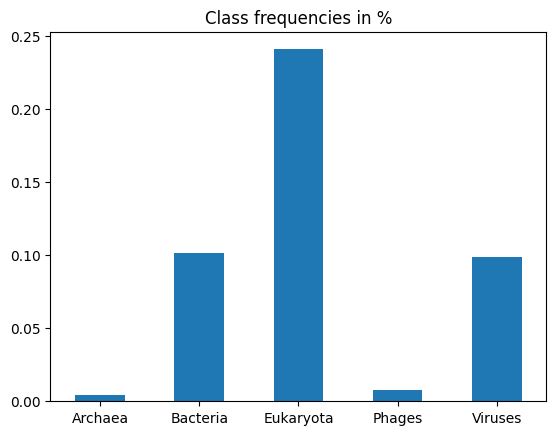

In [9]:
class_frequencies = y.value_counts() / y.sum()
class_frequencies = class_frequencies.sort_index()
class_frequencies.index = ["Archaea", "Bacteria", "Eukaryota", "Phages", "Viruses"]

ax = class_frequencies.plot.bar(rot=0)
plt.title("Class frequencies in %")

It's an unbalanced multiclass classification therefore we'll use **macro-averaged F1-score** used in the article that describes the dataset

Let's split the dataset. We're using stratification to ensure the same distribution of classes in training and testing dataset

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.2, random_state=0, stratify=y
)

Now we're going to perform a training of a knn model

In [11]:
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_jobs=-1)
clf.fit(X_train, y_train)

y_pred_score_train = clf.predict(X_train)
y_pred_score_test = clf.predict(X_test)

f1_train = f1_score(y_train, y_pred_score_train, average="macro")
f1_test = f1_score(y_test, y_pred_score_test, average="macro")

print(f"F1 train: {100 * f1_train:.2f}%")
print(f"F1 test: {100 * f1_test:.2f}%")

F1 train: 92.51%
F1 test: 91.35%


The scores are good but F1 score doesn't tell us everything about the performance. Let's check the confusion matrix

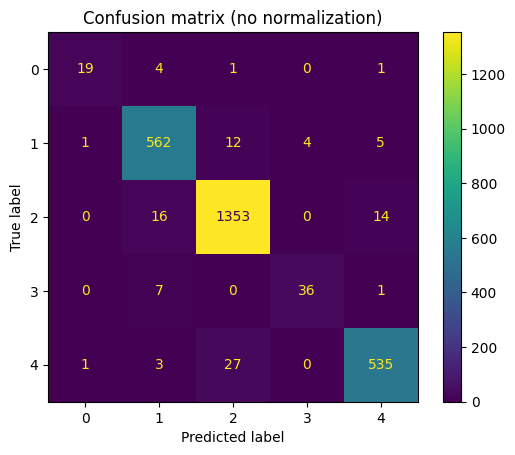

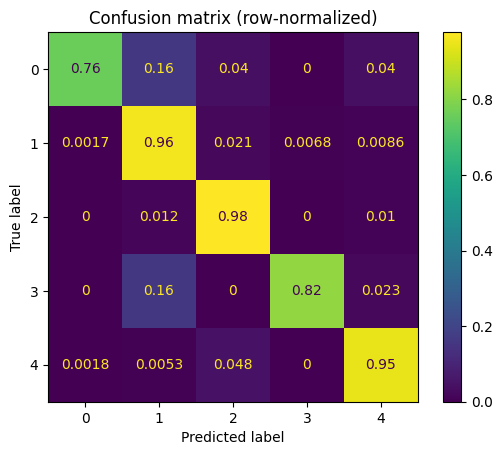

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.title("Confusion matrix (no normalization)")
plt.show()


ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, normalize="true")
plt.title("Confusion matrix (row-normalized)")
plt.show()

We can see that classes 0 (Archaea) and 3 (Bacteriophages) are quite often labelled as 1 (Bacteria)

Lets perform hyperparameter tuning to see if we can perform better

In [13]:
from time import time

from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV


clf = KNeighborsClassifier(n_jobs=-1)

param_grid = {
    "n_neighbors": list(range(1, 51)),
}

multiclass_f1 = make_scorer(
    f1_score,
    average="macro",
    greater_is_better=True,
)

cv = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring=multiclass_f1,
    cv=5,
)

time_start = time()
cv.fit(X_train, y_train)
time_end = time()

print(f"Optimal number of neighbors: {cv.best_params_['n_neighbors']}")
print(f"Tuning time: {time_end - time_start:.2f} s")

y_pred_score_train = cv.predict(X_train)
y_pred_score_test = cv.predict(X_test)

f1_train = f1_score(y_train, y_pred_score_train, average="macro")
f1_test = f1_score(y_test, y_pred_score_test, average="macro")

print(f"F1 train: {100 * f1_train:.2f}%")
print(f"F1 test: {100 * f1_test:.2f}%")

Optimal number of neighbors: 1
Tuning time: 14.35 s
F1 train: 100.00%
F1 test: 89.16%


We experience overfitting and the score is worse than before. Let's see with different hyperparameters and their ranges

In [14]:
clf = KNeighborsClassifier(n_jobs=-1)

param_grid = {
    "n_neighbors": list(range(5, 25)),
    "metric": ["euclidean", "cosine", "manhattan"],
    "weights": ["uniform", "distance"],
}

multiclass_f1 = make_scorer(
    f1_score,
    average="macro",
    greater_is_better=True,
)

cv = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring=multiclass_f1,
    cv=5,
)

time_start = time()
cv.fit(X_train, y_train)
time_end = time()

In [15]:
print(f"Optimal number of neighbors: {cv.best_params_['n_neighbors']}")
print(f"Optimal metric: {cv.best_params_['metric']}")
print(f"Optimal weights:{cv.best_params_['weights']}")

print(f"Tuning time: {time_end - time_start:.2f} s")

y_pred_score_train = cv.predict(X_train)
y_pred_score_test = cv.predict(X_test)

f1_train = f1_score(y_train, y_pred_score_train, average="macro")
f1_test = f1_score(y_test, y_pred_score_test, average="macro")

print(f"F1 train: {100 * f1_train:.2f}%")
print(f"F1 test: {100 * f1_test:.2f}%")

Optimal number of neighbors: 6
Optimal metric: cosine
Optimal weights:distance
Tuning time: 80.14 s
F1 train: 100.00%
F1 test: 91.53%


We still see heavy overfitting but the test score is a bit higher

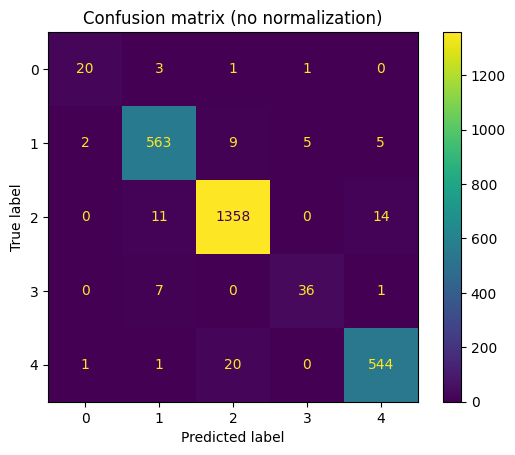

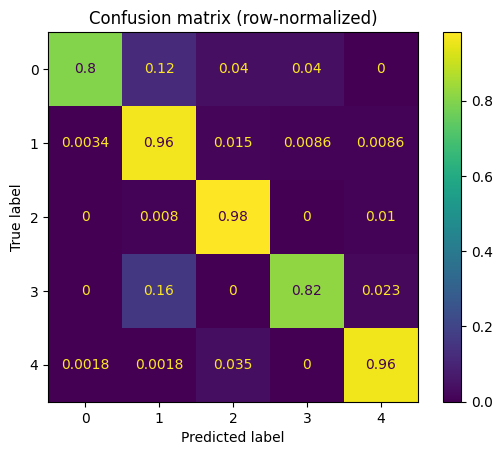

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(cv, X_test, y_test)
plt.title("Confusion matrix (no normalization)")
plt.show()

ConfusionMatrixDisplay.from_estimator(cv, X_test, y_test, normalize="true")
plt.title("Confusion matrix (row-normalized)")
plt.show()

We observer almost no changes in the confusion matrix except of slight improvement for class 0

# Approximate Nearest Neighbours

Let's try to improve our classifier's time performance using approximate nearest neighbours algorithm. In particular, NNDescent algorithm

Scikit learn implements a `KNeighborsTransformer` class and interface for implementation of nearest neighbours algorithms. It allows for integration of external tools. Requires using `metric="precomputed"`

PyNNDescent implementation is implemented in `PyNNDescentTransformer` that inherits from `KNeighborsTransformer`. We're going to create a pipeline object with `make_pipeline()`

For efficiency PyNNDescent uses Numby - A JIT (Just-In-Time) compiler. Running the cell twice is recommended - the second time is going to be much quicker

In [17]:
from time import time


def benchmark_knn_and_ann(
    sklearn_knn,
    pynndescent_ann,
    X_train,
    X_test,
    y_train,
    y_test,
) -> None:
    # training
    start_time = time()
    sklearn_knn.fit(X_train, y_train)
    end_time = time()

    sklearn_knn_fit_time = end_time - start_time

    start_time = time()
    pynndescent_ann.fit(X_train, y_train)
    end_time = time()

    pynndescent_ann_fit_time = end_time - start_time

    # prediction

    start_time = time()
    y_pred_sklearn = sklearn_knn.predict(X_test)
    end_time = time()

    sklearn_knn_predict_time = end_time - start_time

    start_time = time()
    y_pred_pynndescent = pynndescent_ann.predict(X_test)
    end_time = time()

    pynndescent_ann_predict_time = end_time - start_time

    f1_knn = f1_score(y_test, y_pred_sklearn, average="macro")
    f1_ann = f1_score(y_test, y_pred_pynndescent, average="macro")

    print(f"Scikit-learn training time: {sklearn_knn_fit_time:.2f}")
    print(f"PyNNDescent training time: {pynndescent_ann_fit_time:.2f}")
    print()
    print(f"Scikit-learn prediction time: {sklearn_knn_predict_time:.2f}")
    print(f"PyNNDescent prediction time: {pynndescent_ann_predict_time:.2f}")
    print()
    print(f"Scikit-learn F1: {100 * f1_knn:.2f}%")
    print(f"PyNNDescent F1: {100 * f1_ann:.2f}%")

In [18]:
from pynndescent import PyNNDescentTransformer
from sklearn.pipeline import make_pipeline


sklearn_knn = KNeighborsClassifier(metric="euclidean")

pynndescent_ann = make_pipeline(
    PyNNDescentTransformer(metric="euclidean", random_state=0),
    KNeighborsClassifier(metric="precomputed"),
)

benchmark_knn_and_ann(sklearn_knn, pynndescent_ann, X_train, X_test, y_train, y_test)

Scikit-learn training time: 0.00
PyNNDescent training time: 14.52

Scikit-learn prediction time: 0.06
PyNNDescent prediction time: 0.05

Scikit-learn F1: 91.35%
PyNNDescent F1: 91.25%


Let's see the score for manhattan metric

In [19]:
sklearn_knn = KNeighborsClassifier(metric="manhattan")

pynndescent_ann = make_pipeline(
    PyNNDescentTransformer(metric="manhattan", random_state=0),
    KNeighborsClassifier(metric="precomputed"),
)

benchmark_knn_and_ann(sklearn_knn, pynndescent_ann, X_train, X_test, y_train, y_test)

Scikit-learn training time: 0.00
PyNNDescent training time: 6.00

Scikit-learn prediction time: 0.12
PyNNDescent prediction time: 0.09

Scikit-learn F1: 91.39%
PyNNDescent F1: 91.39%


# Binary Classification


For binary classification we'll use [HIV dataset from MoleculeNet benchmark](https://moleculenet.org/datasets-1). The dataset was created for the task of molecular property prediction of HIV inhibitors. The original dataset consists of molecules in SMILES text format, however the dataset that we use has been processed with [ECFP4 fingerprint](https://docs.chemaxon.com/display/docs/extended-connectivity-fingerprint-ecfp.md#:~:text=Extended%2DConnectivity%20Fingerprints%20(ECFPs),a%20wide%20variety%20of%20applications.). The label determines whether a given molecule is a potential inhibitor of HIV.

We're going to use the Area Under Receiver Operating Characteristic (AUROC / ROC AUC) metric as it was used in the [benchmark](https://ogb.stanford.edu/docs/leader_graphprop/)  .

In [20]:
df_train = pd.read_parquet("mol_hiv_train.parquet")
df_valid = pd.read_parquet("mol_hiv_valid.parquet")
df_test = pd.read_parquet("mol_hiv_test.parquet")
y_train = df_train.pop("y")
y_valid = df_valid.pop("y")
y_test = df_test.pop("y")
X_train = np.array(df_train, dtype=bool)
X_valid = np.array(df_valid, dtype=bool)
X_test = np.array(df_test, dtype=bool)

Text(0.5, 1.0, 'Class frequencies in %')

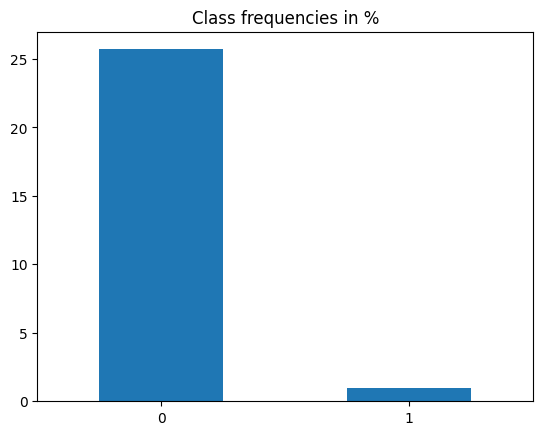

In [21]:
class_frequencies = y_train.value_counts() / y_train.sum()
class_frequencies = class_frequencies.sort_index()
class_frequencies.index = [0, 1]

ax = class_frequencies.plot.bar(rot=0)
plt.title("Class frequencies in %")

Let's train the classifier with jaccard metric

In [22]:
from sklearn.metrics import roc_auc_score

clf = KNeighborsClassifier(n_jobs=-1, metric="jaccard")

time_start = time()
clf.fit(X_train, y_train)
time_end = time()

print(f"Training Time: {time_end - time_start:.2f} s")

time_start = time()
train_prediction = clf.predict_proba(X_train)[:, 1]
time_end = time()

print(f"Train prediction time: {time_end - time_start:.2f} s")

time_start = time()
test_prediction = clf.predict_proba(X_test)[:, 1]
time_end = time()

print(f"Test prediction time: {time_end - time_start:.2f} s")

Training Time: 0.03 s
Train prediction time: 34.07 s
Test prediction time: 4.44 s


In [23]:
train_score = roc_auc_score(y_train, train_prediction)
test_score = roc_auc_score(y_test, test_prediction)

print(f"train: {100 * train_score:.2f}%")
print(f"test: {100 * test_score:.2f}%")

train: 98.10%
test: 73.87%


Let us perform hyperparameter tuning

In [24]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV

X_t = np.concatenate((X_train, X_valid))
y_t = np.concatenate((y_train, y_valid))

split_index = [-1] * len(X_train) + [0] * len(X_valid)
pds = PredefinedSplit(test_fold=split_index)

clf = KNeighborsClassifier(n_jobs=-1, metric="jaccard")

param_grid = {"n_neighbors": [1, 5, 10]}

roc_auc_scorer = make_scorer(
    roc_auc_score,
    greater_is_better=True,
)

cv = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring=roc_auc_scorer,
    cv=pds,
)

time_start = time()
cv.fit(X_t, y_t)
time_end = time()

print(f"Time: {time_end - time_start:.2f} s")
print(f"Optimal number of neighbors: {cv.best_params_['n_neighbors']}")

Time: 12.47 s
Optimal number of neighbors: 1


In [25]:
train_prediction = cv.predict_proba(X_t)[:, 1]
test_prediction = cv.predict_proba(X_test)[:, 1]

train_score = roc_auc_score(y_t, train_prediction)
test_score = roc_auc_score(y_test, test_prediction)

print(f"train: {100 * train_score:.2f}%")
print(f"test: {100 * test_score:.2f}%")

train: 99.80%
test: 61.18%


We can see significant loss of performance. It's most probably caused by good performance of the model on the validation set that rewards a parameter that is not optimal

In [26]:
cv.cv_results_["mean_test_score"]

array([0.65761409, 0.64641204, 0.61629189])

Let's see the scores for PyNNDescent

In [27]:
sklearn_knn = KNeighborsClassifier(metric="jaccard", n_neighbors=5)

pynndescent_ann = make_pipeline(
    PyNNDescentTransformer(metric="jaccard", random_state=0, n_neighbors=5),
    KNeighborsClassifier(metric="precomputed", n_neighbors=5),
)

# training
start_time = time()
sklearn_knn.fit(X_train, y_train)
end_time = time()

sklearn_knn_fit_time = end_time - start_time

start_time = time()
pynndescent_ann.fit(X_train, y_train)
end_time = time()

pynndescent_ann_fit_time = end_time - start_time

# prediction

start_time = time()
y_pred_sklearn = sklearn_knn.predict_proba(X_test)[:, 1]
end_time = time()

sklearn_knn_predict_time = end_time - start_time

start_time = time()
y_pred_pynndescent = pynndescent_ann.predict_proba(X_test)[:, 1]
end_time = time()

pynndescent_ann_predict_time = end_time - start_time

test_score_knn = roc_auc_score(y_test, y_pred_sklearn)
test_score_ann = roc_auc_score(y_test, y_pred_pynndescent)

print(f"Scikit-learn training time: {sklearn_knn_fit_time:.2f}")
print(f"PyNNDescent training time: {pynndescent_ann_fit_time:.2f}")
print()
print(f"Scikit-learn prediction time: {sklearn_knn_predict_time:.2f}")
print(f"PyNNDescent prediction time: {pynndescent_ann_predict_time:.2f}")
print()
print(f"Scikit-learn F1: {100 * test_score_knn:.2f}%")
print(f"PyNNDescent F1: {100 * test_score_ann:.2f}%")

C:\Users\piotr\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Scikit-learn training time: 0.03
PyNNDescent training time: 8.35

Scikit-learn prediction time: 35.09
PyNNDescent prediction time: 0.11

Scikit-learn F1: 73.87%
PyNNDescent F1: 62.44%


We observe great time improvement when using ANN but the performance loss is significant

# Image Search

Let's create a simple image search tool that utilises nearest neighbours algorithms

Download the [dataset](https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-images-small.tar). Extract it next to the notebook. In the `images/metadata` you can find an `images.csv.gz` file - extract it next to the notebook.

In [28]:
# prepare pd.Series with paths to images
image_paths = pd.read_csv("images.csv")

# "height" and "width" are original image size, let's select
# only large ones - they are probably more interesting
mask = (image_paths["height"] >= 1000) & (image_paths["width"] >= 1000)
image_paths = image_paths.loc[mask, :]

# remove columns, leaving only pd.Series with paths
image_paths = image_paths["path"]
image_paths = "images/small/" + image_paths.astype(str)

image_paths

554       images/small/46/4689906d.png
6614      images/small/0c/0cd7596c.jpg
6617      images/small/e6/e602a9af.jpg
6621      images/small/e7/e7cfeb02.jpg
6627      images/small/68/6839db4e.jpg
                      ...             
398207    images/small/6d/6d49d130.jpg
398208    images/small/b1/b163e0ea.jpg
398209    images/small/a1/a116d9d1.jpg
398210    images/small/9c/9c3e1158.jpg
398211    images/small/cf/cf112e38.jpg
Name: path, Length: 342878, dtype: object

In [29]:
from itertools import islice

import joblib
import torch
from PIL import Image
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm

MAX_IMAGES = 10000
BATCH_SIZE = joblib.cpu_count(only_physical_cores=True)


def vectorize_images(image_paths: pd.Series) -> np.ndarray:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = SentenceTransformer("clip-ViT-B-32", device=device)

    # batch iterator, based on Python itertools example
    def batched(iterable, n: int):
        it = iter(iterable)
        while batch := tuple(islice(it, n)):
            yield batch

    # CLIP embeddings have 512 dimensions
    embeddings = np.empty((MAX_IMAGES, 512))

    # iterate with tqdm, it will give us a nice progress bar
    with tqdm(total=MAX_IMAGES) as pbar:
        start_idx = 0
        for batch in batched(image_paths.iloc[:MAX_IMAGES], BATCH_SIZE):
            end_idx = min(start_idx + BATCH_SIZE, MAX_IMAGES)

            # load images with Image.open()
            images = [Image.open(path) for path in batch]

            # calculate embeddings
            emb = model.encode(images)

            # save embeddings in the embeddings array
            embeddings[start_idx:end_idx] = emb

            # update start_idx
            start_idx = end_idx

            pbar.update(BATCH_SIZE)

    return embeddings

In [30]:
embeddings = vectorize_images(image_paths)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [31]:
from pynndescent import NNDescent
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid


class ImageSearch:
    def __init__(self, image_paths: pd.Series, embeddings: np.ndarray):
        # change to Numpy array to avoid .iloc[] and just index with []
        self.image_paths = np.array(image_paths.values)

        # create the embedding model
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = SentenceTransformer("clip-ViT-B-32", device=device)

        # create PyNNDescent index
        self.index = NNDescent(embeddings, metric="cosine", random_state=0, n_jobs=-1)
        del embeddings

    # find 9 nearest neighbours and display the images
    def search(self, text: str, n_neighbors: int = 9) -> None:
        image_paths = self.query(text, n_neighbors)
        self.show(image_paths)

    # encode the text into the embedded space and find 9 nearest neighbours
    def query(self, text: str, n_neighbors: int = 9) -> list[str]:
        emb = self.model.encode([text]).reshape((1, -1))
        idx = self.index.query(emb, n_neighbors)[0]
        return self.image_paths[idx][0]

    # display images
    def show(self, image_paths: list[str]) -> None:
        images = [Image.open(path) for path in image_paths]

        fig = plt.figure(figsize=(4.0, 4.0))
        grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=0.1)

        for ax, im in zip(grid, images):
            ax.imshow(im)
        plt.show()

In [32]:
image_search = ImageSearch(image_paths, embeddings)

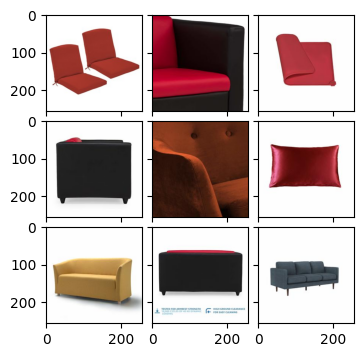

In [33]:
image_search.search("red sofa")